In [ ]:
%pip install transformers datasets supervision ultralytics pycocotools lightning coco_eval

#### Load Dataset

In [1]:
import os

HOME = os.getcwd()

DATASET_DIR = os.path.join(HOME, "my_dataset")

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(DATASET_DIR, "train")
VAL_DIRECTORY = os.path.join(DATASET_DIR, "valid")
TEST_DIRECTORY = os.path.join(DATASET_DIR, "test")

In [ ]:
!mkdir -p $DATASET_DIR
!mkdir -p $TRAIN_DIRECTORY
!mkdir -p $VAL_DIRECTORY
!mkdir -p $TEST_DIRECTORY

In [ ]:
!wget -N -O $TRAIN_DIRECTORY/train.zip https://huggingface.co/datasets/keremberke/satellite-building-segmentation/resolve/main/data/train.zip
!wget -N -O $TEST_DIRECTORY/test.zip https://huggingface.co/datasets/keremberke/satellite-building-segmentation/resolve/main/data/test.zip
!wget -N -O $VAL_DIRECTORY/valid.zip https://huggingface.co/datasets/keremberke/satellite-building-segmentation/resolve/main/data/valid.zip

In [ ]:
!cd $DATASET_DIR
!unzip -q -o $TRAIN_DIRECTORY/train.zip -d $TRAIN_DIRECTORY
!unzip -q -o $VAL_DIRECTORY/valid.zip -d $VAL_DIRECTORY
!unzip -q -o $TEST_DIRECTORY/test.zip -d $TEST_DIRECTORY
!cd $HOME

#### Create COCO data loaders

In [2]:
import torchvision
from transformers import RTDetrImageProcessor

image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r101vd_coco_o365")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(
            image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(
            image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(
            images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of training examples: 6764
Number of validation examples: 1934
Number of test examples: 967


Image #1532


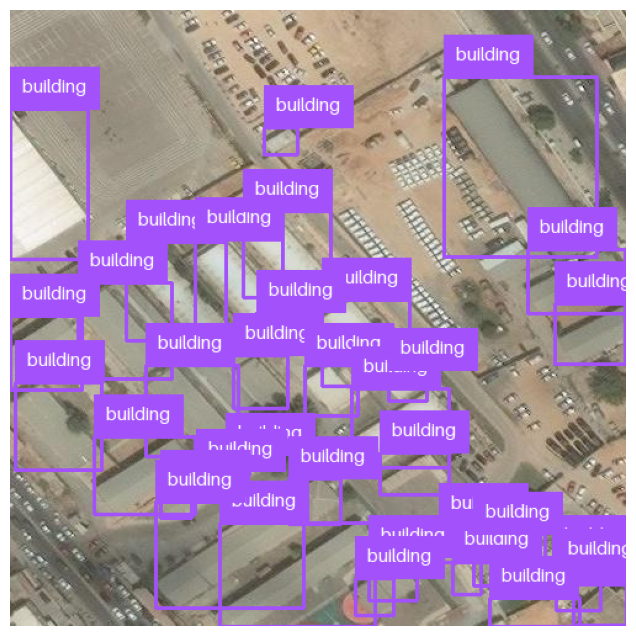

In [3]:
import random
import cv2
import numpy as np
import supervision as sv

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

def from_coco_annotations(coco_annotation: dict) -> sv.Detections:
        xyxy, class_id = [], []

        for annotation in coco_annotation:
            x_min, y_min, width, height = annotation["bbox"]
            xyxy.append([x_min, y_min, x_min + width, y_min + height])
            class_id.append(annotation["category_id"])

        return sv.Detections(xyxy=np.array(xyxy), class_id=np.array(class_id))
    
detections = from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _,_, class_id, _,_
    in detections
]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.RichLabelAnnotator(font_size=15)

annotated_frame=image.copy()

annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels
)

%matplotlib inline  
sv.plot_image(annotated_frame, (8, 8))

In [4]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }


TRAIN_DATALOADER = DataLoader(
    dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(
    dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(
    dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [5]:
import lightning as L

import torch


class RTDetr_Finetunner(L.LightningModule):
    def __init__(self, model, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = model
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()}
                  for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values,
                             pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def test_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("test_loss", loss)
        for k, v in loss_dict.items():
            self.log("test_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # The learning rate strategy of the RT-DETR backbone follows DETR
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {"params": [p for n, p in self.named_parameters(
            ) if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                      weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

    def test_dataloader(self):
        return TEST_DATALOADER

In [6]:
from transformers import RTDetrForObjectDetection
rt_detr = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r101vd_coco_o365",
                                                   num_labels=len(id2label),
                                                   ignore_mismatched_sizes=True)
opt_rt_detr = torch.compile(rt_detr)
model = RTDetr_Finetunner(opt_rt_detr, lr=1e-4,
                          lr_backbone=1e-5, weight_decay=1e-4)

# model = torch.compile(model, fullgraph=True)
batch = next(iter(TRAIN_DATALOADER))
outputs = model(
    pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r101vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model

In [7]:
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


trainer = Trainer(max_epochs=25,
                  min_epochs=10,
                  gradient_clip_val=0.1,
                  accumulate_grad_batches=8,
                  log_every_n_steps=5,
                  callbacks=[EarlyStopping(monitor="validation_loss", min_delta=0.001, mode="min")])
# trainer = Trainer(max_steps=3,
#                   gradient_clip_val=0.1,
#                   accumulate_grad_batches=8,
#                   log_every_n_steps=5)
trainer.fit(model, train_dataloaders=TRAIN_DATALOADER,
            val_dataloaders=VAL_DATALOADER)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
W0906 01:21:16.941000 139632207378240 torch/_dynamo/convert_frame.py:762] [45/8] torch._dynamo hit config.cache_size_limit (8)
W0906 01:21:16.941000 139632207378240 torch/_dynamo/convert_frame.py:762] [45/8]    function: 'get_loss' (/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/transformers/models/rt_detr/modeling_rt_detr.py:2170)
W0906 01:21:16.941000 139632207378240 torch/_dyn

Training: |          | 0/? [00:00<?, ?it/s]

W0906 01:22:02.433000 139632207378240 torch/_dynamo/convert_frame.py:762] [46/8] torch._dynamo hit config.cache_size_limit (8)
W0906 01:22:02.433000 139632207378240 torch/_dynamo/convert_frame.py:762] [46/8]    function: 'loss_boxes' (/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/transformers/models/rt_detr/modeling_rt_detr.py:2072)
W0906 01:22:02.433000 139632207378240 torch/_dynamo/convert_frame.py:762] [46/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0906 01:22:02.433000 139632207378240 torch/_dynamo/convert_frame.py:762] [46/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0906 01:22:02.433000 139632207378240 torch/_dynamo/convert_frame.py:762] [46/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
W0906 01:22:24.042000 139632207378240 torch/_dynamo/convert_frame.py:762] [38/8] torch._dynamo hit config.cache_size_limit (8)
W0906 01:22:24.042000 139632207378240 torch/_dynamo/conver

Validation: |          | 0/? [00:00<?, ?it/s]

/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
W0906 01:32:47.929000 139632207378240 torch/_dynamo/convert_frame.py:762] [55/8] torch._dynamo hit config.cache_size_limit (8)
W0906 01:32:47.929000 139632207378240 torch/_dynamo/convert_frame.py:762] [55/8]    function: '_center_to_corners_format_torch' (/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/transformers/image_transforms.py:512)
W0906 01:32:47.929000 139632207378240 torch/_dynamo/convert_frame.py:762] [55/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0906 01:32:47.929000 139632207378240 torch/_dynamo/convert_frame.py:762] [55/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0906 01:32:47.929000 139632207378240 torch/_dynamo/convert_frame.py:762] [55/8] To diagnose 

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=10` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [8]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at /home/yifeng/projects/satellite-image-roofs-auto-annotation-sourcecode/notebooks/lightning_logs/version_9/checkpoints/epoch=9-step=2120.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/yifeng/projects/satellite-image-roofs-auto-annotation-sourcecode/notebooks/lightning_logs/version_9/checkpoints/epoch=9-step=2120.ckpt
/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

W0906 02:41:33.314000 139632207378240 torch/_dynamo/convert_frame.py:762] [41/8] torch._dynamo hit config.cache_size_limit (8)
W0906 02:41:33.314000 139632207378240 torch/_dynamo/convert_frame.py:762] [41/8]    function: 'torch_dynamo_resume_in_generalized_box_iou_at_2431' (/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/transformers/models/rt_detr/modeling_rt_detr.py:2431)
W0906 02:41:33.314000 139632207378240 torch/_dynamo/convert_frame.py:762] [41/8]    last reason: tensor 'L['boxes2']' dispatch key set mismatch. expected DispatchKeySet(CUDA, BackendSelect, ADInplaceOrView, AutogradCUDA), actual DispatchKeySet(CUDA, BackendSelect)
W0906 02:41:33.314000 139632207378240 torch/_dynamo/convert_frame.py:762] [41/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0906 02:41:33.314000 139632207378240 torch/_dynamo/convert_frame.py:762] [41/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            8.621183395385742
     test_loss_bbox         0.17682340741157532
  test_loss_bbox_aux_0      0.1775393784046173
  test_loss_bbox_aux_1      0.1809992790222168
  test_loss_bbox_aux_2      0.17874233424663544
  test_loss_bbox_aux_3      0.1783050298690796
  test_loss_bbox_aux_4      0.17715230584144592
  test_loss_bbox_aux_5      0.18511970341205597
     test_loss_giou         0.4590482711791992
  test_loss_giou_aux_0      0.46657460927963257
  test_loss_giou_aux_1      0.4669589400291443
  test_loss_giou_aux_2      0.46282103657722473
  test_loss_giou_aux_3      0.46062955260276794
  test_loss_giou_aux_4      0.45902079343795776
  test_loss_giou_aux_5      0.48465538024902344


/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


[{'test_loss': 8.621183395385742,
  'test_loss_vfl': 0.577464759349823,
  'test_loss_bbox': 0.17682340741157532,
  'test_loss_giou': 0.4590482711791992,
  'test_loss_vfl_aux_0': 0.6019557118415833,
  'test_loss_bbox_aux_0': 0.1775393784046173,
  'test_loss_giou_aux_0': 0.46657460927963257,
  'test_loss_vfl_aux_1': 0.5884255766868591,
  'test_loss_bbox_aux_1': 0.1809992790222168,
  'test_loss_giou_aux_1': 0.4669589400291443,
  'test_loss_vfl_aux_2': 0.5859874486923218,
  'test_loss_bbox_aux_2': 0.17874233424663544,
  'test_loss_giou_aux_2': 0.46282103657722473,
  'test_loss_vfl_aux_3': 0.5760871171951294,
  'test_loss_bbox_aux_3': 0.1783050298690796,
  'test_loss_giou_aux_3': 0.46062955260276794,
  'test_loss_vfl_aux_4': 0.5782483220100403,
  'test_loss_bbox_aux_4': 0.17715230584144592,
  'test_loss_giou_aux_4': 0.45902079343795776,
  'test_loss_vfl_aux_5': 0.5986238718032837,
  'test_loss_bbox_aux_5': 0.18511970341205597,
  'test_loss_giou_aux_5': 0.48465538024902344}]

Image #869


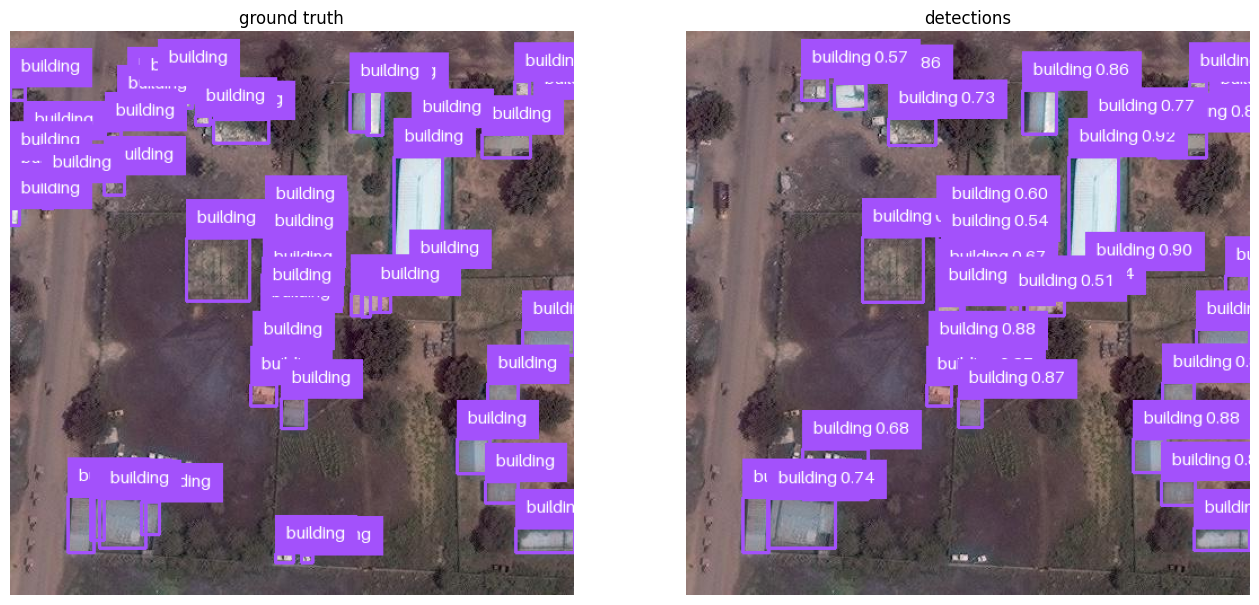

In [9]:
import random
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, _, class_id, _, _ in detections]
frame = image.copy()

frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(
    scene=frame,
    detections=detections,
    labels=labels
)

CONFIDENCE_TRESHOLD = 0.5
rt_detr = model.model
# inference
with torch.no_grad():
    rt_detr.to(device)

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = rt_detr(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(
    transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _,
          _, confidence, class_id, _, _ in detections]
inference_frame = image.copy()

inference_frame = box_annotator.annotate(
    scene=inference_frame, detections=detections)
inference_frame = label_annotator.annotate(
    scene=inference_frame,
    detections=detections,
    labels=labels
)

annotation_labels = ['ground truth', 'detections']

sv.plot_images_grid([frame, inference_frame], (1, 2),
                    annotation_labels, (16, 32))

In [ ]:
%tensorboard

In [10]:
def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = torchvision.ops.box_convert(
            boxes, in_fmt="xyxy", out_fmt="xywh").tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [11]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
        outputs = model(
            pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack(
        [target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(
        outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(
    ): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/242 [00:00<?, ?it/s]

W0906 02:43:47.878000 139632207378240 torch/_dynamo/convert_frame.py:762] [1/8] torch._dynamo hit config.cache_size_limit (8)
W0906 02:43:47.878000 139632207378240 torch/_dynamo/convert_frame.py:762] [1/8]    function: 'forward' (/home/yifeng/miniconda3/envs/mytorch/lib/python3.12/site-packages/transformers/models/rt_detr/modeling_rt_detr.py:1701)
W0906 02:43:47.878000 139632207378240 torch/_dynamo/convert_frame.py:762] [1/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0906 02:43:47.878000 139632207378240 torch/_dynamo/convert_frame.py:762] [1/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0906 02:43:47.878000 139632207378240 torch/_dynamo/convert_frame.py:762] [1/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [12]:
# from huggingface_hub import notebook_login

# notebook_login()

In [13]:
model_directory = os.path.join(HOME, "my_model")
rt_detr.save_pretrained(model_directory)
image_processor.save_pretrained(model_directory)

['/home/yifeng/projects/satellite-image-roofs-auto-annotation-sourcecode/notebooks/my_model/preprocessor_config.json']

In [16]:
# from huggingface_hub import create_repo

repo_name = "Yifeng-Liu/rt-detr-finetuned-for-satellite-image-roofs-detection"

# # Create the repository
# create_repo(repo_name, private=False)

In [18]:
rt_detr.push_to_hub(repo_name)
image_processor.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Yifeng-Liu/rt-detr-finetuned-for-satellite-image-roofs-detection/commit/f163b2bed5ab4ac89ddda1ff26f74a48f476308f', commit_message='Upload processor', commit_description='', oid='f163b2bed5ab4ac89ddda1ff26f74a48f476308f', pr_url=None, pr_revision=None, pr_num=None)